### Groq Client and relevant imports

In [19]:
#!pip install groq
#!pip install dotenv
#!pip install agentic-patterns
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.9 MB/s eta 0:00:00


In [10]:
from pprint import pprint
from groq import Groq
from dotenv import load_dotenv
from IPython.display import display_markdown
import os
# Set Groq API key
os.environ["GROQ_API_KEY"]= "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"
client = Groq()

## The Crew

In [11]:
from agentic_patterns.multiagent_pattern.crew import Crew

class GroqLLM:
    def __init__(self, model="llama3-70b-8192"):
        self.client = Groq()
        self.model = model

    def complete(self, prompt):
        response = self.client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=self.model,
            temperature=0.7
        )
        return type('obj', (object,), {'text': response.choices[0].message.content})

In [16]:
import re
from agentic_patterns.multiagent_pattern.crew import Crew
from datetime import datetime
import os

# Assuming llm is initialized earlier
llm = GroqLLM(model="llama3-70b-8192")

class DraftCompletionAgent:
    def __init__(self, llm):
        self.name = "Draft Completion Agent"
        self.dependencies = []
        self.dependents = []
        self.llm = llm
        self.user_inputs = {}
        self.output = None

    def ask_user(self, question_key, question_text):
        print(f"{question_text}")
        user_input = input("→ ")
        self.user_inputs[question_key] = user_input

    def run(self):
        questions = [
            ("wife_name", "1. Full name of the wife (plaintiff):"),
            ("wife_father", "2. What is the father’s name of the wife?"),
            ("wife_cnic", "3. What is the CNIC number of the wife?"),
            ("wife_address", "3. Current address of the wife:"),
            ("husband_name", "4. Full name of the husband (defendant):"),
            ("husband_father", "5. Father’s name of the husband:"),
            ("husband_address", "6. Address of the husband:"),
            ("marriage_date_city", "7. City and date of marriage:"),
            ("haq_mehr", "8. Haq Mehr amount and whether paid:"),
            ("children", "9. Any children? Provide names and dates of birth:"),
            ("separation_duration", "10. Duration of separation:"),
            ("maintenance", "11. Has husband paid any maintenance?"),
            ("khula_reasons", "12. Reasons for seeking Khula:"),
            ("divorce_requests", "13. Have you requested divorce? What was his response?"),
            ("cause_recent", "14. When did the cause of action arise?"),
            ("filing_city", "15. City where this suit will be filed:"),
            ("lawyer_name", "16. Do you want to include lawyer's name? If yes, enter full name."),
        ]

        print("📄 Let's collect details for your Khula Petition:")

        for key, text in questions:
            self.ask_user(key, text)

        formatted = "\n".join([f"{key}: {val}" for key, val in self.user_inputs.items()])
        generation_prompt = f"""Using the following information, draft a formal Khula Petition for submission in a Pakistani Family Court. Structure it using professional legal formatting including paragraphs, prayer, and verification. Use formal respectful tone:

{formatted}

Start now:"""

        self.output = self.llm.complete(generation_prompt).text
        return f"✅ Draft Completed:\n\n{self.output[:800]}..."


class PlainTextCleanerAgent:
    def __init__(self):
        self.name = "Plain Text Cleaner Agent"
        self.dependencies = []
        self.dependents = []
        self.output = None

    def clean_text(self, text):
        # Remove Markdown headings, formatting, special bullets, and double newlines
        cleaned = re.sub(r"#.*", "", text)  # remove headings
        cleaned = re.sub(r"\*\*(.*?)\*\*", r"\1", cleaned)  # bold markdown
        cleaned = re.sub(r"[_*`~\-•▪️▶️➤→◼️]", "", cleaned)  # misc symbols
        cleaned = re.sub(r"\n\s*\n", "\n", cleaned)  # excessive newlines
        cleaned = re.sub(r"\s{2,}", " ", cleaned)  # remove extra spaces
        return cleaned.strip()

    def run(self):
        raw_text = next(iter(self.dependencies)).output
        self.output = self.clean_text(raw_text)
        return f"🧹 Cleaned text ready for writing.\nPreview:\n{self.output[:500]}..."


class KhulaFileWriterAgent:
    def __init__(self):
        self.name = "Khula File Writer Agent"
        self.dependencies = []
        self.dependents = []
        self.output = None

    def run(self):
        final_text = next(iter(self.dependencies)).output
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        os.makedirs("outputs", exist_ok=True)
        filename = f"outputs/khula_petition_clean_{timestamp}.txt"

        with open(filename, "w", encoding="utf-8") as f:
            f.write(final_text)

        self.output = f"📝 File saved to {filename}"
        return self.output


# Crew setup
with Crew() as crew:
    drafter = DraftCompletionAgent(llm)
    cleaner = PlainTextCleanerAgent()
    file_writer = KhulaFileWriterAgent()

    # Register agents
    crew.add_agent(drafter)
    crew.add_agent(cleaner)
    crew.add_agent(file_writer)

    # Set dependencies
    cleaner.dependencies.append(drafter)
    drafter.dependents.append(cleaner)

    file_writer.dependencies.append(cleaner)
    cleaner.dependents.append(file_writer)

    print("🚀 Launching Khula Petition Workflow (with cleaning)...")
    crew.run()


🚀 Launching Khula Petition Workflow (with cleaning)...

RUNNING AGENT: <__main__.DraftCompletionAgent object at 0x7894e63ef490>

📄 Let's collect details for your Khula Petition:
1. Full name of the wife (plaintiff):
→ Razia Khadim
2. What is the father’s name of the wife?
→ Ali Rizvi
3. What is the CNIC number of the wife?
→ 35409-89092920-2
3. Current address of the wife:
→ House 90, Muhallah XYZ, Lahore
4. Full name of the husband (defendant):
→ Waheed Khan
5. Father’s name of the husband:
→ Murtaza Khan
6. Address of the husband:
→ House 67, Shahdara Town, Lahore
7. City and date of marriage:
→ Lahore, 23-09-2020
8. Haq Mehr amount and whether paid:
→ 200000, not paid
9. Any children? Provide names and dates of birth:
→ One, Umer, 23-10-2022
10. Duration of separation:
→ 1 year
11. Has husband paid any maintenance?
→ No
12. Reasons for seeking Khula:
→ Domestic Violence
13. Have you requested divorce? What was his response?
→ Yes, denied
14. When did the cause of action arise?
→ Sin

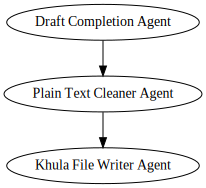

In [17]:
crew.plot()